# Chapter 8- Decision Trees Laboratory

We first use classification trees  to analyze the `Carseats` data set.
In these data, `Sales` is a continuous variable, and so we begin by recoding it  as a binary variable.

In [1]:
!pip install git+https://github.com/JakeColtman/bartpy.git 

  Cloning https://github.com/JakeColtman/bartpy.git to /tmp/pip-req-build-p5kcjsnb
  Running command git clone -q https://github.com/JakeColtman/bartpy.git /tmp/pip-req-build-p5kcjsnb
  Created wheel for bartpy: filename=bartpy-0.0.2-py3-none-any.whl size=52937 sha256=13831df6361b357de3c8a5acfee60b33b800081fd63eb0c0319412761160678e
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1idg01o/wheels/d9/23/41/d13943255fc60cbf0a088b80529b2f060fb36b00b229ba518e
Successfully built bartpy


In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3 MB 5.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [49]:
import pandas as pd
import numpy as np


from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor, StackingClassifier, VotingClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error

# Require extra installation
from bartpy.sklearnmodel import SklearnModel 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import graphviz 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Fitting classification trees
The current data we have is of an organization who sells car seats, each row represents a region. Therefore for each region, the columns are - 

- **Sales**: unit sales in thousands
- **CompPrice**: price charged by competitor at each location
- **Income**: community income level in 1000s of dollars
- **Advertising**: local ad budget at each location in 1000s of dollars
- **Population**: regional pop in thousands
- **Price**: price for car seats at each site
- **ShelveLoc**: Bad, Good or Medium indicates quality of shelving location
- **Age**: age level of the population
- **Education**: ed level at location
- **Urban**: Yes/No
- **US**: Yes/No

The company wants to set up a busniess in some new region, we have the information of that region and want to predict what the sales would be. To make the model we will use this data as training data source.

We create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds $8$, and takes on a value of `No` otherwise.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
Carseats = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Carseats.csv')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

Carseats.head()


(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0.0


In [6]:
predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True) #sklearn does not have built-in support for categorical variable 
y = Carseats["High"]

In [7]:
X

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,0,0,1,1
1,111,48,16,260,83,65,10,1,0,1,1
2,113,35,10,269,80,59,12,0,1,1,1
3,117,100,4,466,97,55,14,0,1,1,1
4,141,64,3,340,128,38,13,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14,1,0,1,1
396,139,23,3,37,120,55,11,0,1,0,1
397,162,26,12,368,159,40,18,0,1,1,1
398,100,79,7,284,95,50,12,0,0,1,1


The best found split may vary across different runs, even if `max_features=n_features`. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random. To obtain a deterministic behaviour during fitting, random_state

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [8]:
clf_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1, criterion='entropy')
clf_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=1)

One of the most attractive properties of trees is that they can be  graphically displayed. We use the `plot_tree()` function to display the tree structure, and the `export_text` function to display the node labels. The argument `feature_names` instructs `Python` to include the feature names for any predictors, rather than simply displaying a number.

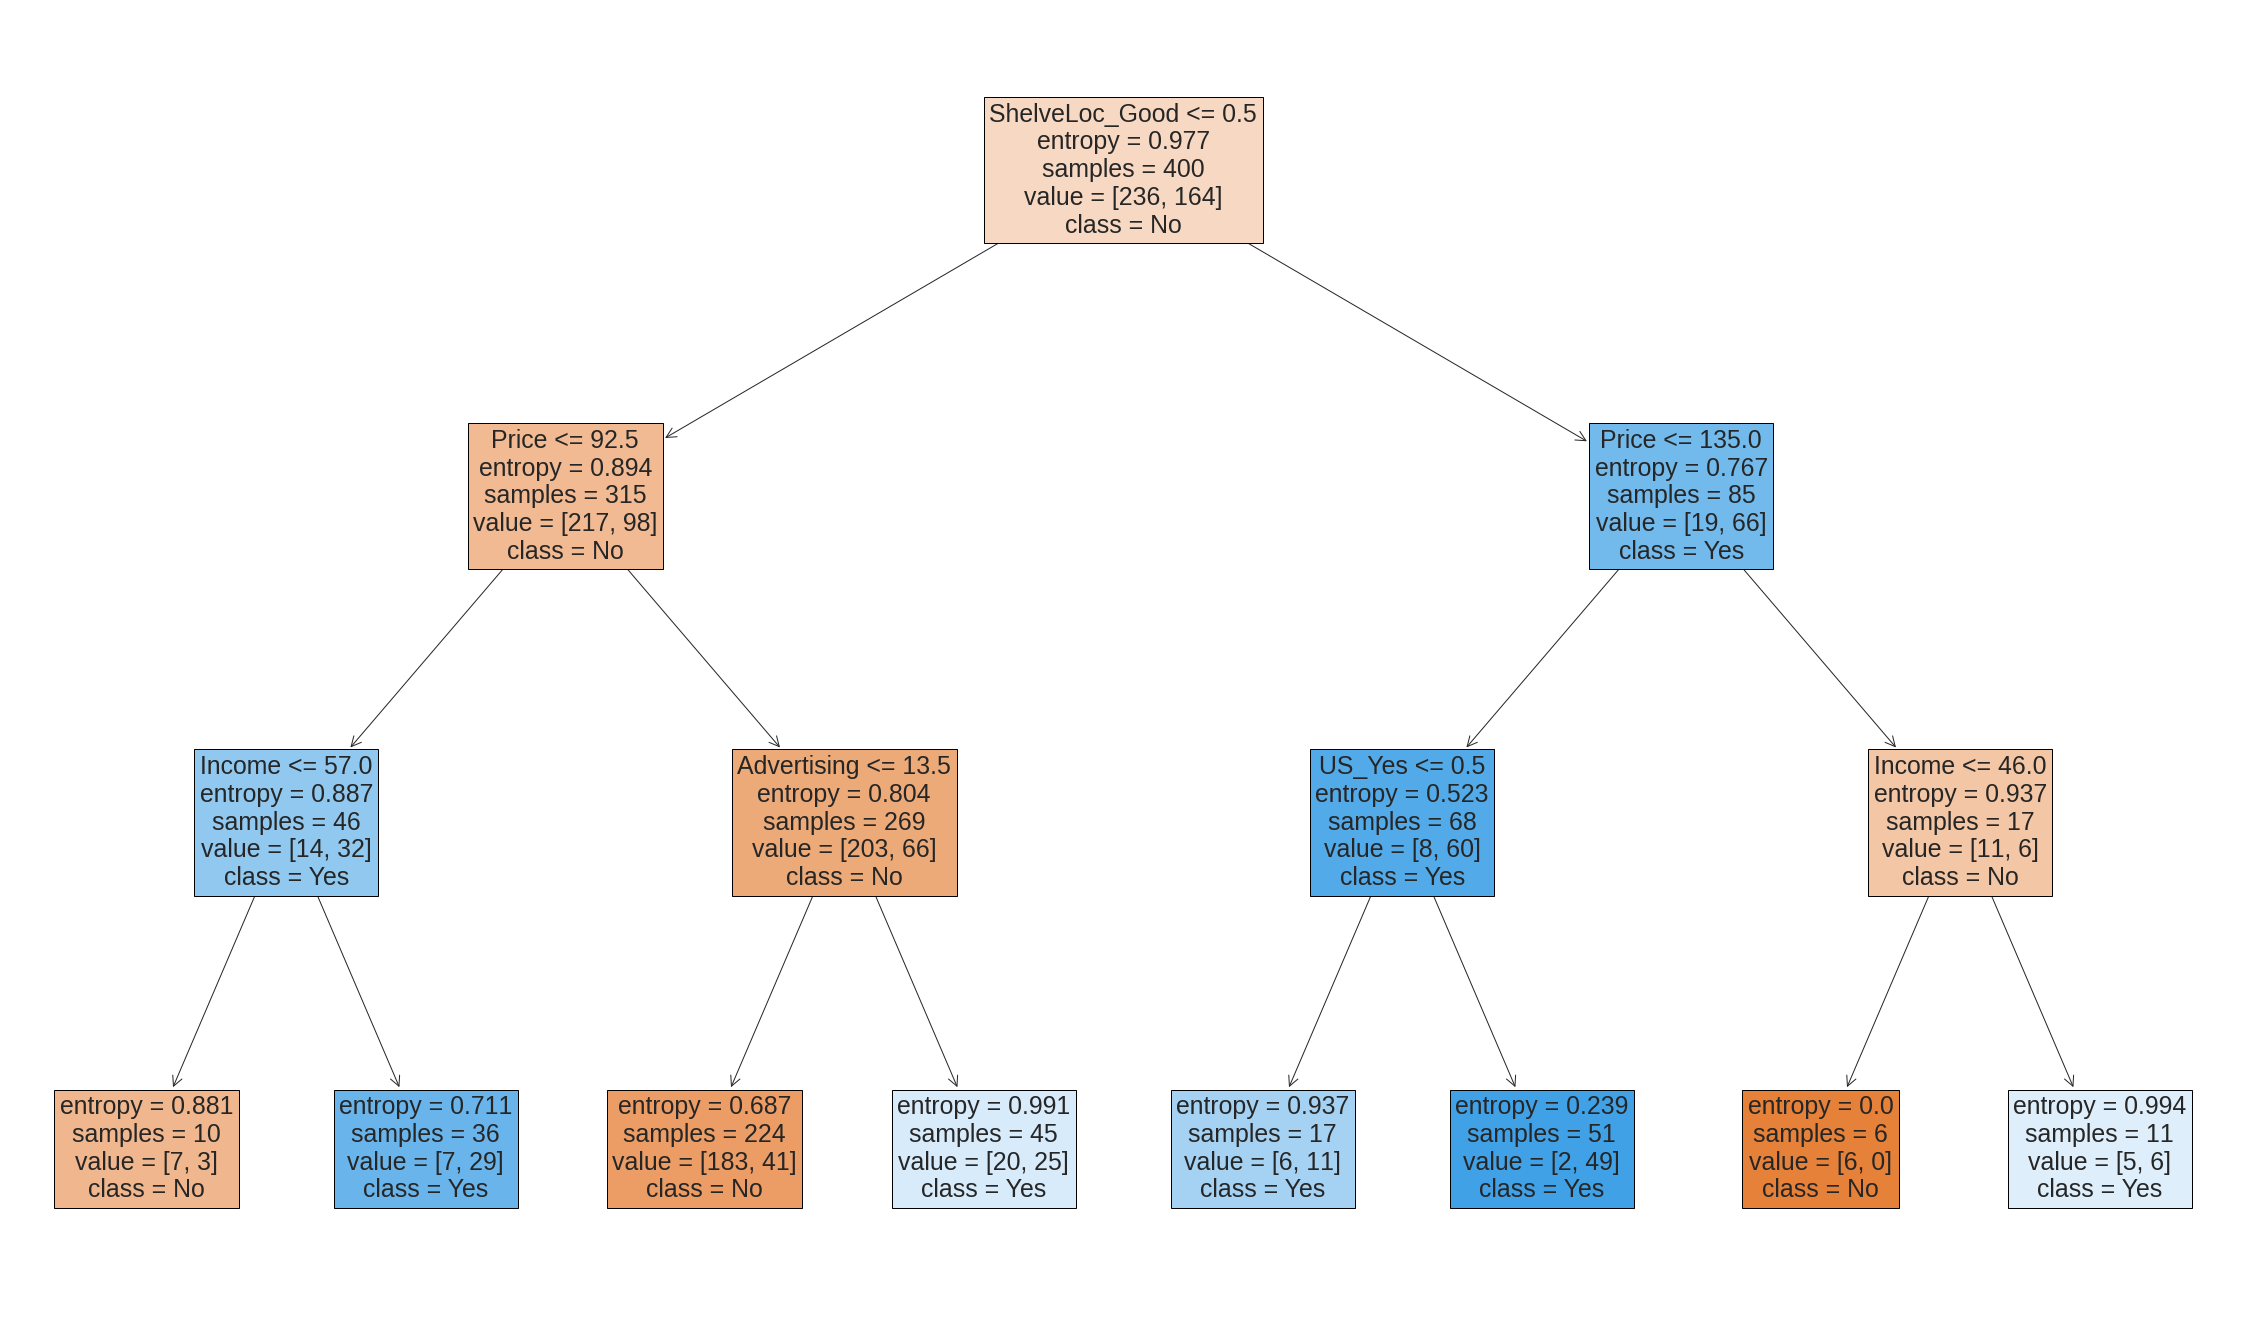

In [9]:
plt.figure(figsize=(40,24))
tree.plot_tree(clf_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True)
plt.show()

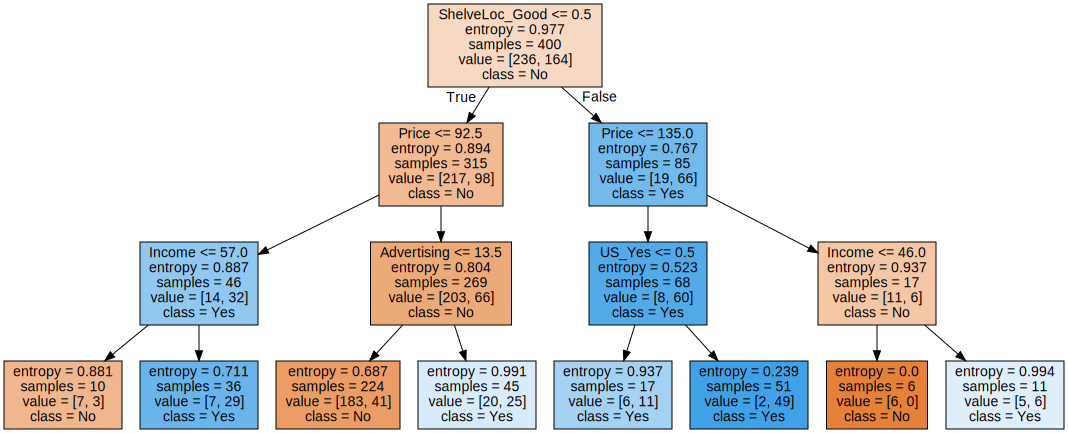

In [10]:
dot_data = tree.export_graphviz(clf_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree1")
graph 

In [11]:
r = tree.export_text(clf_tree, feature_names=list(X.columns))
print(r)

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- class: 0.0
|   |   |--- Income >  57.00
|   |   |   |--- class: 1.0
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- class: 0.0
|   |   |--- Advertising >  13.50
|   |   |   |--- class: 1.0
|--- ShelveLoc_Good >  0.50
|   |--- Price <= 135.00
|   |   |--- US_Yes <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- US_Yes >  0.50
|   |   |   |--- class: 1.0
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- class: 0.0
|   |   |--- Income >  46.00
|   |   |   |--- class: 1.0



The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.

For more information about understanding the structure and decision path https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

In [12]:
#clf_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=1, criterion='entropy')
clf_tree = DecisionTreeClassifier(max_leaf_nodes=30, random_state=1, criterion='entropy')
clf_tree.fit(X, y)
clf_tree.score(X, y)

0.9375

We see that the training error rate is  $6.25\%$ when we set the `max_leaf_nodes` to 30. In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The `predict()` function can be used for this purpose. This approach leads to correct predictions for around $73\,\%$ of the locations in the test data set.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)
clf_tree = DecisionTreeClassifier(max_leaf_nodes=30, random_state=1, criterion='entropy')
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)
y_pred_prob = clf_tree.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, y_pred)     
print(conf_mat)
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )
print("AUC Score: ", roc_auc_score(y_test, y_pred_prob[:,1]) )

[[100  19]
 [ 35  46]]
Accuracy:  0.73
Sensitivity:  0.5679012345679012
Precision:  0.7076923076923077
False Positive Rate:  0.15966386554621848
AUC Score:  0.7327523602033406


Again, If you re-run the `fit()` function then you might get slightly different results, due to "ties": for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `Yes` and `No` response values. So remember to set the `random_state`

Next, we consider whether pruning the tree might lead to improved  results. We use cross-validation in order to  determine the optimal size of tree complexity.

The tree now consider the number of terminal nodes.

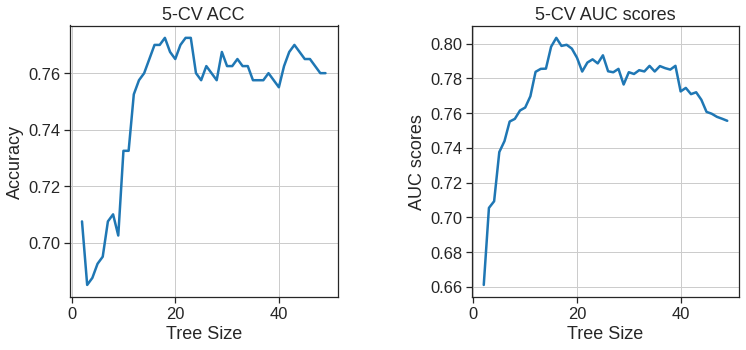

In [14]:
tree_sizes = range(2, 50)

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

ACC_scores = []
AUC_scores = []

# 10-Fold CV for each tree size 
for size in tree_sizes:
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=size, random_state=1, criterion='entropy')
    ACC_s = cross_val_score(clf_tree, X, y, cv=kf5, scoring='accuracy')
    AUC_s = cross_val_score(clf_tree, X, y, cv=kf5, scoring='roc_auc')
    ACC_scores.append(np.mean(ACC_s))
    AUC_scores.append(np.mean(AUC_s))
    
# plot CV-Accuracy and AUC socres w.r.t tree sizes 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))          
fig.subplots_adjust(wspace=0.5)

ax1.plot(tree_sizes, ACC_scores)
ax1.set_title('5-CV ACC')
ax1.set_xlabel('Tree Size')
ax1.set_ylabel('Accuracy')
ax1.grid(True)

ax2.plot(tree_sizes, AUC_scores)
ax2.set_title('5-CV AUC scores')
ax2.set_xlabel('Tree Size')
ax2.set_ylabel('AUC scores')
ax2.grid(True)

In [15]:
np.array(ACC_scores).argmax()

16

How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

In [16]:
clf_tree = DecisionTreeClassifier(max_leaf_nodes=18, random_state=1, criterion='entropy')
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)
y_pred_prob = clf_tree.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, y_pred)     
print(conf_mat)
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )
print("AUC Score: ", roc_auc_score(y_test, y_pred_prob[:,1]) )

[[100  19]
 [ 32  49]]
Accuracy:  0.745
Sensitivity:  0.6049382716049383
Precision:  0.7205882352941176
False Positive Rate:  0.15966386554621848
AUC Score:  0.772849880693018


Now $74.5\,\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.

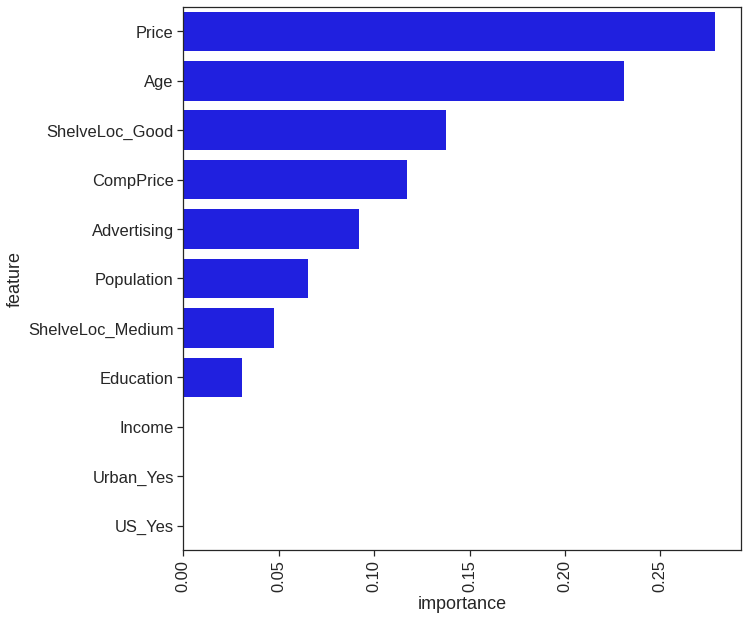

In [17]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.columns, 'importance': clf_tree.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

cost complexity pruning can also be used in order to select a sequence of trees for consideration.

In [18]:
clf_tree = DecisionTreeClassifier(random_state=1, criterion='entropy')
path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

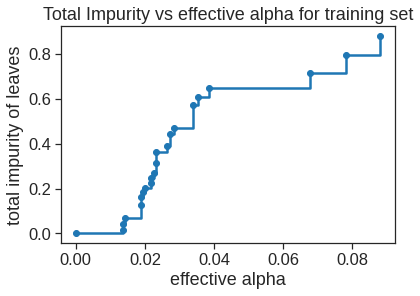

In [19]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, criterion='entropy', ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0974240009819235


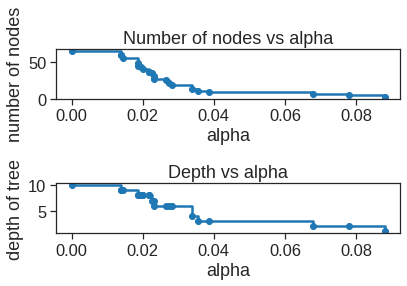

In [21]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Check https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html and https://scikit-learn.org/stable/modules/tree.html for more details

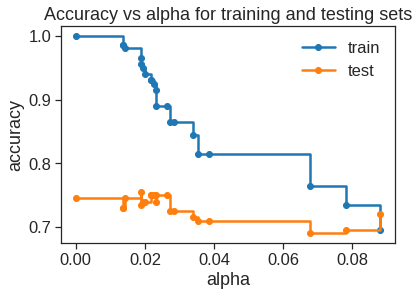

In [22]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Other metrics `min_samples_leaf` and `max_depth` can also be used  to prevent a tree from overfiting

## Fitting Regression Trees

Here we fit a regression tree to the `Boston`  data set. First, we create a training set, and fit the tree to the training data.

In [53]:
# Load 'Boston' data
Boston = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Boston.csv')
Boston = Boston.drop('Unnamed: 0', axis=1)
Boston.info()    # all numeric.  no Null,  Nice 
Boston.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [54]:
X = Boston.drop('medv', axis=1)
y = Boston.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

In [25]:
reg_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=1)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=1)

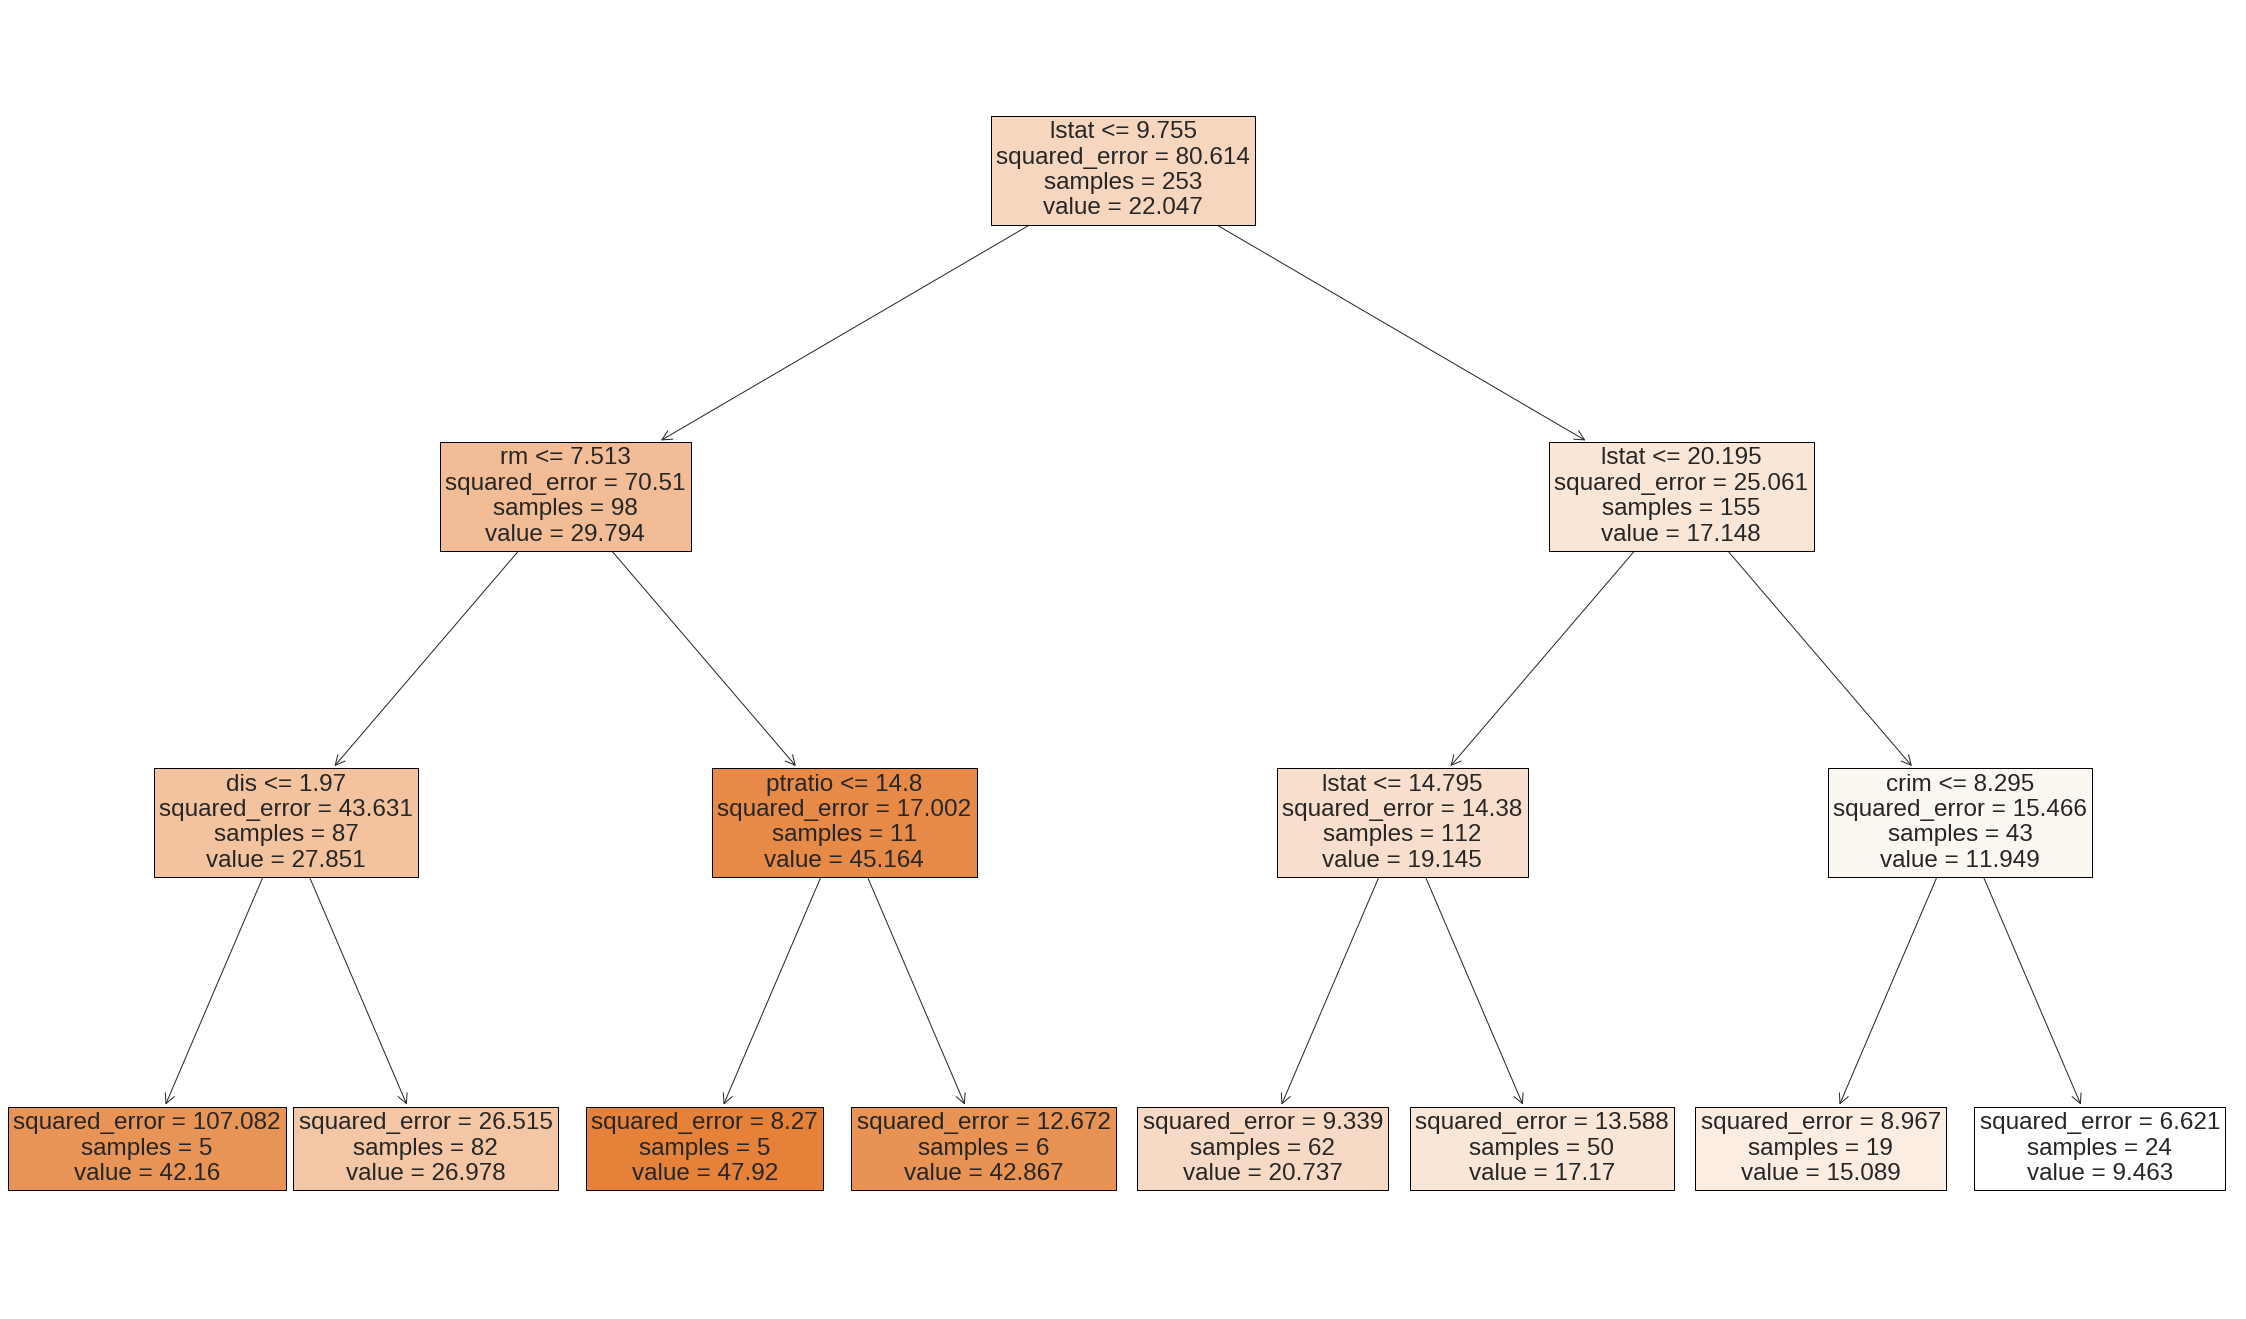

In [26]:
plt.figure(figsize=(40,24))
tree.plot_tree(reg_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True)
plt.show()

The variable `lstat` measures the percentage of individuals with {lower  socioeconomic status}, while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger values of `rm`, or lower values of `lstat`, correspond to more expensive houses.

Now we use the cross validation to see whether pruning the tree will improve performance.

best tree size =  7


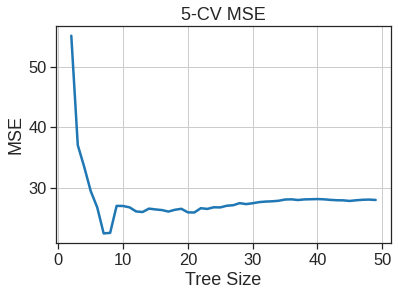

In [27]:
tree_sizes = range(2, 50)

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

MSE_scores = []

# 7-Fold CV for each tree size 
for size in tree_sizes:
    reg_tree = DecisionTreeRegressor(max_leaf_nodes=size, random_state=1)
    MSE_s = -cross_val_score(reg_tree, X, y, cv=kf5, scoring='neg_mean_squared_error')
    MSE_scores.append(np.mean(MSE_s))
    
# plot CV-MSE as tree size gets bigger 
plt.plot(tree_sizes, MSE_scores)
plt.title('5-CV MSE')
plt.xlabel('Tree Size')
plt.ylabel('MSE')
plt.grid(True)

print("best tree size = ", tree_sizes[np.argmin(MSE_scores)]) #np.argmin(MSE_scores)=5

In [28]:
reg_tree = DecisionTreeRegressor(max_leaf_nodes=7, random_state=1)
reg_tree.fit(X_train, y_train)
pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

17.924645209941158 4.2337507260042075


Text(0, 0.5, 'y_test')

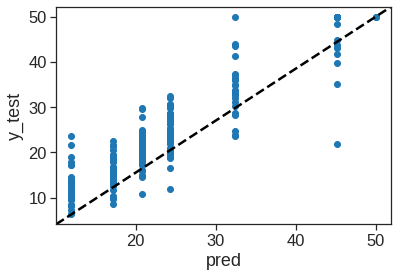

In [29]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In other words, the  test set MSE associated with the regression tree is $17.92$.
The square root of the MSE is therefore around $4.234$, indicating that this model leads to test predictions that are (on average) within approximately $4,234$ of the true median home value for the census tract.


## Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [30]:
# Bagging: using all features
max_features = X.shape[1]
tree_count   = 100
regr1 = RandomForestRegressor(max_features=max_features, random_state=2, n_estimators=tree_count)
regr1.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=2)

The argument `max_features=12` indicates that all 12 predictors should be considered for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

11.56611499209486 3.4008991446520227


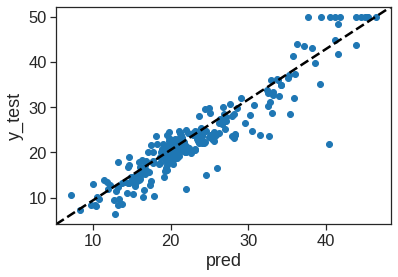

In [31]:
pred = regr1.predict(X_test)
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

We can grow a random forest in exactly the same way, except that we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [32]:
# Random forests: using 6 features
tree_count   = 100
regr2 = RandomForestRegressor(max_features=6, random_state=2, n_estimators=tree_count)
regr2.fit(X_train, y_train)

pred = regr2.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

11.210173703557313 3.3481597488108767


The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `feature_importances` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

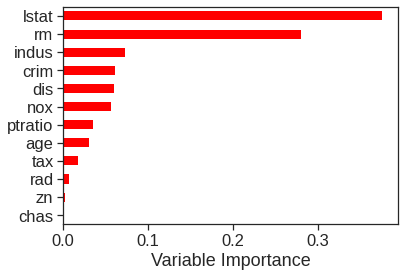

In [33]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_}, index=X.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.



## Boosting

Here we use the `GradientBoostingRegressor()` function, to fit boosted regression trees to the `Boston` data set. 

In [34]:
# Gradient boosting

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'max_features': 'sqrt', 'subsample' : 0.9,
          'learning_rate': 0.01, 'loss': 'squared_error', 'random_state': 1}

regr3   = GradientBoostingRegressor(**params)
regr3.fit(X_train, y_train)

pred = regr3.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

10.585712502747185 3.2535691943997724


In [35]:
# Gradient boosting

params = {'n_estimators': 100, 'max_features': 'sqrt', 
          'learning_rate': 0.1, 'random_state': 10}

regr3   = GradientBoostingRegressor(**params)
regr3.fit(X_train, y_train)

pred = regr3.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

10.377996557875113 3.2214898040929936


The test MSE obtained is $10.38$: this is superior to the test MSE of random forests and bagging.

Train/Test Split GBR with 500 estimators: 10.3780


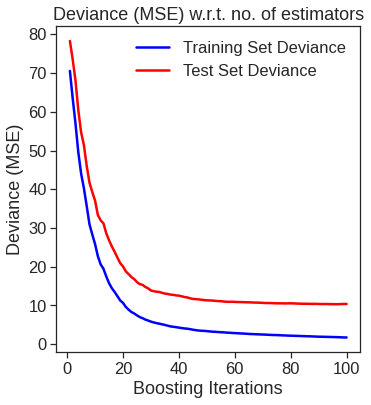

In [36]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

# compute test set deviance
for i, y_pred in enumerate(regr3.staged_predict(X_test)):   
    test_score[i] = regr3.loss_(y_test, y_pred)             

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance (MSE) w.r.t. no. of estimators')
plt.plot(np.arange(params['n_estimators']) + 1, regr3.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance (MSE)')
print("Train/Test Split GBR with 500 estimators: %.4f" % test_score[-1])

chas       0.001323
rad        0.002557
zn         0.020765
age        0.023923
tax        0.051350
crim       0.061762
ptratio    0.075320
dis        0.096075
indus      0.098711
nox        0.105943
lstat      0.219331
rm         0.242939
dtype: float64


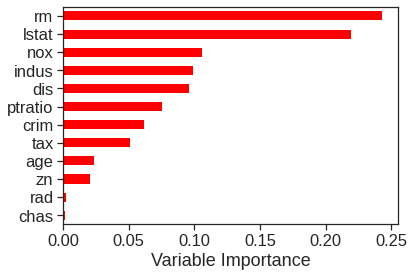

In [37]:
feature_importance = regr3.feature_importances_
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


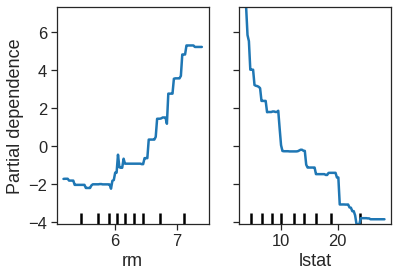

In [38]:
# Partial Dependence Plots
disp1 = plot_partial_dependence(regr3,  X_train, [5, 11], feature_names=X.columns)  

### AdaBoost

In [40]:
ada_regr = AdaBoostRegressor(n_estimators=100, random_state=1)

ada_regr.fit(X_train, y_train)

pred = ada_regr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

15.134274042481255 3.8902794298714913


Check https://scikit-learn.org/stable/modules/ensemble.html#adaboost for more detail

### Some popular gradient boosting framework

In [41]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

[13:05:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
10.94928405888066 3.3089702414619357


In [42]:
lgb = LGBMRegressor()
lgb.fit(X_train,y_train)
pred = lgb.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

14.122950479186711 3.7580514205086004


In [43]:
cgb = CatBoostRegressor(verbose=0)
cgb.fit(X_train,y_train)
pred = cgb.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

9.778667968221665 3.1270861785729003


## Bayesian Additive Regression Trees

In this section  we use the `bartpy` package, and within it the `SklearnModel()` function, to fit a Bayesian additive regression tree model to the `Boston` housing data set. **On colab the following code may takes 5~10 minutes to run with default value**.


In [55]:
model = SklearnModel() # Use default parameters
model.fit(X_train, y_train) # Fit the model

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

13.855191004718163 3.7222561712915683


Chcek https://jakecoltman.github.io/bartpy/ for more details

## Voting and Stacking

In [44]:
Carseats = pd.read_csv('/content/drive/MyDrive/NSYSU/00_Statistical_learning/Lab/Data/Carseats.csv')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True) #sklearn does not have built-in support for categorical variable 
y = Carseats["High"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

(400, 11)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf1 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=10))
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

estimators = [
    ("knn", clf1),   
    ("dc", clf2),
    ("nb", clf3)
]

vclf = VotingClassifier(estimators=estimators, voting='hard')

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

print('5-fold cross validation:\n')


for clf, label in zip([clf1, clf2, clf3, vclf], 
                      ['KNN', 
                       'DecisionTreeClassifier', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.82 (+/- 0.04) [StackingClassifier]


Check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html for more details

In [47]:
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'DecisionTreeClassifier', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.81 (+/- 0.05) [StackingClassifier]


Check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html or http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#stackingcvclassifier for more details